# Notebook Description

In this notebook, I attempt to use machine learning to predict whether or not a golfer will make the cut at the Masters Tournament. The models used take inputs consisting of full season aggregate statistics from the previous year to make the predictions for that year's Masters Tournament (e.g., the models used 2018 full season data to predict 2019 results.

Additionally, we will use the subset of golfers that make the cut to attempt to predict the top 10 come Sunday evening at Augusta using the same inputs as before.

# Necessary Packages and Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

# Webscrapping
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup

# Regression
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.linear_model import Lasso, Ridge, LinearRegression

# Sklearn - Classification
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler as ROS

# Graphing
%matplotlib inline
sns.set_style('darkgrid')
figsize = (15,8)
hspace = 0.5

# Pickling
import pickle
from sklearn.externals import joblib

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Helper Functions

## Webscrapping

In [2]:
# PGATour.com Webscrapping Function
def get_PGA_Tour_data(stats, seasons):

    """
    This function pings the PGA Tour's server and gathers the desired statistics
    (by inserting the stat_id into the url) and appends it to our data container
    """

    data = []
    
    for season in seasons:  
        print(f"Beginning {season} season:")
        for stat in stats: 
            url = f"https://www.pgatour.com/content/pgatour/stats/stat.{stat['stat_id']}.y{season}.html"

            #opening up connection, grabbing the page
            uClient = uReq(url)
            page_html = uClient.read()

            #html parsing using BeautifulSoup
            page_soup = soup(page_html, 'html.parser')

            #find the table where stats are kept
            tbody = page_soup.find('tbody')

            #each golfer is separated by a <tr> tag
            raw_golfers = tbody.findAll('tr')

            #loop through each golfer, grab name and avg. distance
            for raw_golfer in raw_golfers:
                golfer = {}
                golfer['season'] = season            
                name = raw_golfer.find('td', {'class':'player-name'}).a.text
                golfer['full_name'] = name.replace(' ', '_').lower()
                golfer[f"{stat['stat_name']}"] = raw_golfer.find('td', {'class':None}).text
                data.append(golfer)
            print(f" {stat['stat_name']} stats added for the {season} season")
        print(f"{season} season completed.\n")

    #close the client
    uClient.close()

    return data

## Convert Strings to Feet

In [3]:
# Convert stats to feet function
def convert_to_feet(x):
    """
    This function takes in a string and returns a float
    """
    
    if type(x) == str:
        y = x.replace("'","").replace('"',"").split()

        if len(y) == 1:
            y.extend([0])
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

        else:
            for i in range(len(y)):
                y[i] = int(y[i])
            return y[0]+(y[1]/12)

    else:
        return np.nan

## Format Golfer

In [4]:
# Format golfer names from results Dataframe
def format_golfer(x):
    return x.replace(' ','_').lower()

## Plotter Functions

### Confusion Matrix Plotter

In [5]:
# creates the confusion matrix
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure(figsize=(5,4));
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")


    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

### Feature Importance Plotter

In [6]:
# creates feature importance graphs
def plot_feature_importances(X_train, model, n_features, FI_labels):
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), FI_labels) 
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')

# Data Gathering and Cleaning

## Data Gathering

### Desired Features

In [7]:
# # The stat_id will be inserted into the url for each ping
# stats = [
#     {'stat_name': 'driving_distance',
#      'stat_id': '101'},
#     {'stat_name': 'driving_accuracy', 
#      'stat_id': '102'},
#     {'stat_name': 'greens_in_regulation', 
#      'stat_id': '103'},
#     {'stat_name': 'proximity', 
#      'stat_id': '331'},
#     {'stat_name': 'scrambling_rough',  
#      'stat_id': '363'},
#     {'stat_name': 'scrambling_sand',  
#      'stat_id': '362'},
#     {'stat_name': 'putting_conversion',
#      'stat_id': '115'},
#     {'stat_name': 'putting_rating',
#      'stat_id': '402'},
#     {'stat_name': 'sg_off_tee',
#      'stat_id': '02567'},
#     {'stat_name': 'sg_approach',
#      'stat_id': '02568'},
#     {'stat_name': 'sg_scrambling',  
#      'stat_id': '02569'},
#     {'stat_name': 'sg_putting',
#      'stat_id': '02564'},
#     {'stat_name': 'sg_tee_to_green',  
#      'stat_id': '02674'},
#     {'stat_name': 'sg_total',  
#      'stat_id': '02675'},
#     {'stat_name': 'scoring_avg',  
#      'stat_id': '120'},
# ]

### Seasons Considered

In [8]:
# # Since strokes_gained stats only go back to 2004, we will consider 2004-2019
# seasons = range(2004, 2020)

### Webscrapping and Dataframe Conversion

In [9]:
# # Call the web scrapping helper function defined above. Save the results and examine Dataframe
# data = get_PGA_Tour_data(stats, seasons)

In [10]:
# # Convert data to Dataframe and save raw data locally
# df = pd.DataFrame(data)
# df.to_csv('csv_files/raw_golfer_data.csv')

## Data Cleaning

### Convert Features

In [11]:
# Reload raw data and examine dataframe
df = pd.read_csv('csv_files/raw_golfer_data.csv', index_col=0)
df.drop('str_diff_to_field', axis=1, inplace=True)
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(48592, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,hank_kuehne,314.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,scott_hend,312.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2004,john_daly,306.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2004,mike_heinen,305.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2004,chris_smith,304.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Convert proximity to feet floats and str_diff_to_field to stroke floats
df['proximity'] = df['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
df['driving_accuracy'] = df['driving_accuracy']/100
df['greens_in_regulation'] = df['greens_in_regulation']/100
df['scrambling_rough'] = df['scrambling_rough']/100
df['scrambling_sand'] = df['scrambling_sand']/100
df['putting_conversion'] = df['putting_conversion']/100

### Groupby Season and Golfer

In [13]:
# Group stats by season and golfer
df = df.groupby(['season', 'full_name'])[
    'driving_distance','driving_accuracy','greens_in_regulation','proximity',
    'scrambling_rough','scrambling_sand','putting_conversion','putting_rating',
    'sg_off_tee','sg_approach','sg_scrambling','sg_putting','sg_tee_to_green',
    'sg_total','scoring_avg'].mean()

# Save grouped data locally
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine data
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(3036, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Add Missing Golfers

In [14]:
# Import new csv file that contains data on missing golfers
missing = pd.read_csv('csv_files/masters_results - missing.csv')

print(missing.shape)
missing.head()

(29, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,trevor_immelman,282.3,63.89,60.34,"36' 5""",50.85,48.48,25.45,1.633,0.057,0.282,-0.031,-1.020,0.308,0.207,71.224
1,2005,ángel_cabrera,311.2,53.30,63.33,"37' 10""",54.29,47.50,29.03,1.665,0.531,0.067,0.141,-0.136,0.739,0.603,70.669
2,2006,paul_casey,305.3,62.66,67.17,"32' 1""",45.00,53.57,26.42,1.707,0.118,1.385,-0.249,-0.641,1.254,0.613,70.837
3,2007,andres_romero,312.5,56.25,58.89,"33' 10""",76.47,62.16,26.42,1.572,1.988,-0.457,0.342,0.416,1.873,2.289,68.653
4,2007,robert_karlsson,298.9,51.02,57.54,"36' 2""",51.55,44.44,27.36,1.631,-0.130,-0.219,-0.025,-0.374,-0.022,-0.396,71.396


In [15]:
# Convert the features of missing golfers
missing['proximity'] = missing['proximity'].apply(lambda x: convert_to_feet(x))

# Convert percentage features to decimals
missing['driving_accuracy'] = missing['driving_accuracy']/100
missing['greens_in_regulation'] = missing['greens_in_regulation']/100
missing['scrambling_rough'] = missing['scrambling_rough']/100
missing['scrambling_sand'] = missing['scrambling_sand']/100
missing['putting_conversion'] = missing['putting_conversion']/100

In [16]:
concat = [df, missing]
df = pd.concat(concat)

In [17]:
df.sort_values(by=['season', 'full_name'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)
df.head()

(3065, 17)


,season,full_name,driving_distance,driving_accuracy,greens_in_regulation,proximity,scrambling_rough,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,aaron_baddeley,288.0,0.5308,0.5817,39.333333,0.5769,0.5351,0.3015,1.576,-0.530,-0.679,0.201,0.579,-1.008,-0.429,71.614
1,2004,adam_scott,295.4,0.5765,0.6560,35.333333,0.5301,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
2,2004,alex_cejka,285.8,0.6421,0.6381,36.083333,0.5108,0.5765,0.2877,1.625,0.119,0.255,0.020,-0.006,0.394,0.388,71.153
3,2004,andre_stolz,297.9,0.5897,0.6300,36.416667,0.4632,0.5244,0.2838,1.628,-0.333,-0.532,-0.137,-0.246,-1.002,-1.247,72.341
4,2004,arjun_atwal,289.4,0.6048,0.6252,35.916667,0.5979,0.4107,0.2980,1.606,0.013,-0.097,-0.116,-0.034,-0.200,-0.234,71.688


### Incorporate Historical Tournament Data

In [18]:
# Load Masters Results data and format each golfer to match our data's format
masters_results = pd.read_csv('csv_files/masters_results - data.csv')
masters_results['full_name'] = masters_results['full_name'].apply(lambda x: format_golfer(x))
masters_results = masters_results.sort_values(by=['masters_year', 'full_name'])

print(masters_results.shape)
masters_results.head()

(1469, 7)


,masters_year,full_name,total_score,prior_score,made_cut,top_10,champion
2,2005,adam_scott,294,315,1,0,0
16,2005,austin_eaton_iii,315,315,0,0,0
3,2005,ben_crenshaw,315,315,0,0,0
4,2005,ben_curtis,315,315,0,0,0
44,2005,bernhard_langer,289,285,1,0,0


In [19]:
# Merge dataframes together on name
df = pd.merge(df, masters_results, how='left', on='full_name')

# Drop Nans
df.dropna(inplace=True)

# Only consider rows where golfer participated the following masters
df = df[df['masters_year']-df['season'] == 1]

# Drop Masters year and reset Index
df.drop('masters_year', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

# Change made_cut and top_10 to integers
df['made_cut'] = df['made_cut'].astype(int)
df['top_10'] = df['top_10'].astype(int)
df['champion'] = df['champion'].astype(int)
df['total_score'] = df['total_score'].astype(int)
df['prior_score'] = df['prior_score'].astype(int)

# Reorder columns and examine new dataframe
cols = ['season', 'full_name', 'champion', 'top_10', 'made_cut', 'total_score', 'prior_score',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation', 'proximity',
        'scrambling_rough', 'scrambling_sand', 'putting_conversion', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
        'sg_total', 'scoring_avg']

df = df[cols]

print(df.shape)
df.head()

(953, 22)


,season,full_name,champion,top_10,made_cut,total_score,prior_score,driving_distance,driving_accuracy,greens_in_regulation,...,scrambling_sand,putting_conversion,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg
0,2004,adam_scott,0,0,1,294,315,295.4,0.5765,0.6560,...,0.6170,0.3290,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096
1,2004,ben_curtis,0,0,0,315,315,282.1,0.6434,0.6335,...,0.4583,0.2513,1.620,0.171,0.274,0.223,-0.174,0.669,0.494,71.578
2,2004,bernhard_langer,0,0,1,289,285,282.2,0.6257,0.6525,...,0.4483,0.2768,1.608,0.029,0.616,0.055,-0.229,0.700,0.471,71.246
3,2004,bo_van_pelt,0,0,0,315,315,294.4,0.6515,0.6768,...,0.4369,0.3136,1.623,0.512,0.194,0.094,0.346,0.800,1.146,70.245
4,2004,carlos_franco,0,0,0,315,315,290.6,0.5933,0.6846,...,0.5843,0.2838,1.637,0.130,0.413,0.236,-0.134,0.779,0.645,70.768


# Feature Engineering

## Birdie or Better Distance
Generate a circle where the radius equals a golfer's maximum distance from the hole in which the golfer will make a birdie or better from

In [20]:
df['otg_area'] = df['proximity']**2 * np.pi
df['bob_area'] = df['otg_area']*df['putting_conversion']
df['bob_distance'] = np.sqrt(df['bob_area']/np.pi)
df.drop(['proximity', 'putting_conversion',
         'otg_area', 'bob_area'], axis=1, inplace=True)

## Field Average Score
Create a column that is the average score of the field that year for each golfer

In [21]:
# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut', 'total_score',
        'prior_score', 'driving_distance', 'driving_accuracy', 'greens_in_regulation',
        'scrambling_rough', 'scrambling_sand', 'putting_rating', 'sg_off_tee',
        'sg_approach', 'sg_scrambling', 'sg_putting', 'sg_tee_to_green',
        'sg_total', 'scoring_avg', 'bob_distance'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

print(df.shape)
df.head()

(953, 21)


,full_name,season,champion,top_10,made_cut,total_score,prior_score,driving_distance,driving_accuracy,greens_in_regulation,...,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
0,aaron_baddeley,2006,0,0,1,307,315,288.3,0.6073,0.5826,...,0.5271,1.553,-0.106,-0.607,0.196,0.595,-0.517,0.078,71.197,21.326667
1,aaron_baddeley,2007,0,0,0,315,307,291.9,0.6000,0.6035,...,0.5905,1.570,0.152,-0.252,0.535,0.629,0.435,1.064,70.088,21.005830
2,aaron_baddeley,2008,0,0,1,284,315,290.3,0.5945,0.6202,...,0.5694,1.577,0.096,-0.192,0.218,0.762,0.123,0.885,70.196,21.109307
3,aaron_baddeley,2010,0,0,1,293,315,298.9,0.5665,0.6460,...,0.5766,1.587,0.112,-0.797,0.391,0.502,-0.294,0.208,70.995,21.237521
4,aaron_baddeley,2011,0,0,1,293,293,296.2,0.5567,0.6548,...,0.5673,1.536,0.190,0.196,0.438,0.324,0.824,1.148,70.230,21.490982


In [22]:
# Get each year's Masters Tournament average score for the field
hist_scores = pd.DataFrame(df.groupby('season')['prior_score'].mean())
hist_scores.reset_index(drop=False, inplace=True)
hist_scores['prior_afs'] = hist_scores['prior_score'].astype(int)
hist_scores.drop('prior_score', axis=1, inplace=True)

# Merge with our dataframe
df = pd.merge(df, hist_scores, how='inner', on='season')

## Strokes Gained On Field
Create a new column that calculates how much better (or worse) the golfer did than the field average that year

In [23]:
# Reorder and examine dataframe
cols = ['full_name', 'season', 'champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'prior_afs', 'driving_distance',
        'driving_accuracy', 'greens_in_regulation', 'scrambling_rough',
        'scrambling_sand', 'putting_rating', 'sg_off_tee', 'sg_approach',
        'sg_scrambling', 'sg_putting', 'sg_tee_to_green', 'sg_total',
        'scoring_avg', 'bob_distance']

df = df[cols]

print(df.shape)
df.head()

(953, 22)


,full_name,season,champion,top_10,made_cut,total_score,prior_score,prior_afs,driving_distance,driving_accuracy,...,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
0,aaron_baddeley,2006,0,0,1,307,315,302,288.3,0.6073,...,0.5271,1.553,-0.106,-0.607,0.196,0.595,-0.517,0.078,71.197,21.326667
1,adam_scott,2006,0,0,1,300,292,302,301.1,0.6200,...,0.5283,1.627,0.955,1.115,0.160,-0.130,2.230,2.101,68.946,18.605405
2,arron_oberholser,2006,0,0,1,310,288,302,285.0,0.6253,...,0.5467,1.642,0.095,0.589,0.243,0.167,0.927,1.095,69.858,18.822897
3,bart_bryant,2006,0,0,0,315,315,302,282.2,0.7276,...,0.4211,1.670,0.299,0.379,-0.145,-0.138,0.533,0.395,70.745,16.733242
4,ben_crane,2006,0,0,0,315,315,302,285.8,0.6351,...,0.4815,1.581,-0.233,-0.408,0.272,0.849,-0.369,0.480,70.834,21.400502


In [24]:
# Create column
df['sg_on_field'] = df['prior_afs']-df['prior_score']

# Reorder dataframe so that it is sorted by golfer and than seaon
df = df.groupby(['full_name', 'season'])['champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'prior_afs', 'sg_on_field',
        'driving_distance', 'driving_accuracy', 'greens_in_regulation',
        'scrambling_rough', 'scrambling_sand', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting',
        'sg_tee_to_green', 'sg_total', 'scoring_avg', 'bob_distance'].mean()

# Save and reload csv
df.to_csv('csv_files/golfer_data.csv')

# Reload and examine dataframe
df = pd.read_csv('csv_files/golfer_data.csv')

## Experience and Rolling Averages

In [25]:
# Generate a list of unique golfers and nan values to poulate 2019
golfers = df['full_name'].unique().tolist()

# Create a list of dictionaries to house each golfers prior score at the Masters for every year
names_and_scores = []
for golfer in golfers:
    name_and_scores = {}
    name_and_scores['golfer'] = golfer
    prior_scores = []
    strokes_gained_on_field = []
    for i in range(df.shape[0]):
        if golfer == df['full_name'].iloc[i]:
            prior_scores.append(df['prior_score'].iloc[i])
            strokes_gained_on_field.append(df['sg_on_field'].iloc[i])
        else:
            continue
    name_and_scores['prior_scores'] = prior_scores
    name_and_scores['strokes_gained_on_field'] = strokes_gained_on_field
    names_and_scores.append(name_and_scores)

# Loop through list of dictionaries and create a rolling avg of prior scores list for each golfer
for golfer in names_and_scores:
    prior_scores_rolling_avg = []
    strokes_gained_rolling_avg = []
    experiences = []
    i = 1
    while i <= len(golfer['prior_scores']):
        prior_score_rolling_avg = np.mean(golfer['prior_scores'][:i])
        prior_scores_rolling_avg.append(prior_score_rolling_avg)
        sg_rolling_avg = np.mean(golfer['strokes_gained_on_field'][:i])
        strokes_gained_rolling_avg.append(sg_rolling_avg)
        experience = len(prior_scores_rolling_avg)
        experiences.append(experience)
        i += 1
    golfer['ps_roll_avg'] = prior_scores_rolling_avg
    golfer['sg_roll_avg'] = strokes_gained_rolling_avg
    golfer['experience'] = experiences

# Join all of the sepearate lists together
prior_scores_rolling_avg = []
strokes_gained_rolling_avg = []
experiences = []
for golfer in names_and_scores:
    prior_scores_rolling_avg.extend(golfer['ps_roll_avg'])
    strokes_gained_rolling_avg.extend(golfer['sg_roll_avg'])
    experiences.extend(golfer['experience'])

# Add to our dataframe
df['experience'] = experiences
df['ps_roll_avg'] = prior_scores_rolling_avg
df['sg_roll_avg'] = strokes_gained_rolling_avg

# Reorder and examine dataframe
cols = ['full_name', 'season', 'experience', 'champion', 'top_10', 'made_cut',
        'total_score', 'prior_score', 'ps_roll_avg', 'prior_afs', 'sg_on_field',
        'sg_roll_avg', 'driving_distance', 'driving_accuracy', 'greens_in_regulation',
        'scrambling_rough', 'scrambling_sand', 'putting_rating',
        'sg_off_tee', 'sg_approach', 'sg_scrambling', 'sg_putting',
        'sg_tee_to_green', 'sg_total', 'scoring_avg', 'bob_distance']

df = df[cols]

print(df.shape)
df.head()

(953, 26)


,full_name,season,experience,champion,top_10,made_cut,total_score,prior_score,ps_roll_avg,prior_afs,...,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
0,aaron_baddeley,2006,1,0,0,1,307,315,315.000000,302,...,0.5271,1.553,-0.106,-0.607,0.196,0.595,-0.517,0.078,71.197,21.326667
1,aaron_baddeley,2007,2,0,0,0,315,307,311.000000,305,...,0.5905,1.570,0.152,-0.252,0.535,0.629,0.435,1.064,70.088,21.005830
2,aaron_baddeley,2008,3,0,0,1,284,315,312.333333,302,...,0.5694,1.577,0.096,-0.192,0.218,0.762,0.123,0.885,70.196,21.109307
3,aaron_baddeley,2010,4,0,0,1,293,315,313.000000,300,...,0.5766,1.587,0.112,-0.797,0.391,0.502,-0.294,0.208,70.995,21.237521
4,aaron_baddeley,2011,5,0,0,1,293,293,309.000000,299,...,0.5673,1.536,0.190,0.196,0.438,0.324,0.824,1.148,70.230,21.490982


# Holdout Set

In [26]:
# Create holdout set of 2019 data. Holdout set will be used for predicting 2020 Masters results
holdout = df[df['season'] == 2019]
df = df[df['season'] != 2019]

# Examine holdout and dataframe
print(f"Holdout Set: {holdout.shape}")
print(f"Validation Set: {df.shape}")

# Overwrite grouped data and save both the holdout set and grouped dataframe locally
holdout.to_csv('csv_files/holdout_data.csv')
df.to_csv('csv_files/no_2019_golfer_data.csv')

Holdout Set: (58, 26)
Validation Set: (895, 26)


# Exploratory Data Analysis

## General Information

In [27]:
df = pd.read_csv('csv_files/no_2019_golfer_data.csv', index_col=0)

print(df.shape)
df.head(10)

(895, 26)


,full_name,season,experience,champion,top_10,made_cut,total_score,prior_score,ps_roll_avg,prior_afs,...,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
0,aaron_baddeley,2006,1,0,0,1,307,315,315.000000,302,...,0.5271,1.553,-0.106,-0.607,0.196,0.595,-0.517,0.078,71.197,21.326667
1,aaron_baddeley,2007,2,0,0,0,315,307,311.000000,305,...,0.5905,1.570,0.152,-0.252,0.535,0.629,0.435,1.064,70.088,21.005830
2,aaron_baddeley,2008,3,0,0,1,284,315,312.333333,302,...,0.5694,1.577,0.096,-0.192,0.218,0.762,0.123,0.885,70.196,21.109307
3,aaron_baddeley,2010,4,0,0,1,293,315,313.000000,300,...,0.5766,1.587,0.112,-0.797,0.391,0.502,-0.294,0.208,70.995,21.237521
4,aaron_baddeley,2011,5,0,0,1,293,293,309.000000,299,...,0.5673,1.536,0.190,0.196,0.438,0.324,0.824,1.148,70.230,21.490982
5,aaron_wise,2018,1,0,0,1,281,315,315.000000,294,...,0.4257,1.619,0.410,0.012,0.042,0.238,0.464,0.703,70.247,20.845250
7,adam_hadwin,2016,1,0,0,1,294,315,315.000000,304,...,0.5556,1.586,0.223,-0.055,-0.081,0.530,-0.011,0.519,70.719,20.325521
8,adam_hadwin,2017,2,0,0,1,287,294,304.500000,299,...,0.6607,1.587,0.003,0.183,-0.044,0.409,0.143,0.551,70.583,20.035188
9,adam_scott,2004,1,0,0,1,294,315,315.000000,303,...,0.6170,1.611,0.180,0.571,-0.147,0.824,0.603,1.427,70.096,20.266678
10,adam_scott,2005,2,0,0,1,292,294,304.500000,303,...,0.4286,1.635,0.441,0.566,0.024,0.016,1.030,1.047,70.198,17.385582


In [28]:
top10 = df[df['top_10'] == 1]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 895 entries, 0 to 952
Data columns (total 26 columns):
full_name               895 non-null object
season                  895 non-null int64
experience              895 non-null int64
champion                895 non-null int64
top_10                  895 non-null int64
made_cut                895 non-null int64
total_score             895 non-null int64
prior_score             895 non-null int64
ps_roll_avg             895 non-null float64
prior_afs               895 non-null int64
sg_on_field             895 non-null int64
sg_roll_avg             895 non-null float64
driving_distance        895 non-null float64
driving_accuracy        895 non-null float64
greens_in_regulation    895 non-null float64
scrambling_rough        895 non-null float64
scrambling_sand         895 non-null float64
putting_rating          895 non-null float64
sg_off_tee              895 non-null float64
sg_approach             895 non-null float64
sg_scrambling 

In [30]:
top10.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159 entries, 15 to 948
Data columns (total 26 columns):
full_name               159 non-null object
season                  159 non-null int64
experience              159 non-null int64
champion                159 non-null int64
top_10                  159 non-null int64
made_cut                159 non-null int64
total_score             159 non-null int64
prior_score             159 non-null int64
ps_roll_avg             159 non-null float64
prior_afs               159 non-null int64
sg_on_field             159 non-null int64
sg_roll_avg             159 non-null float64
driving_distance        159 non-null float64
driving_accuracy        159 non-null float64
greens_in_regulation    159 non-null float64
scrambling_rough        159 non-null float64
scrambling_sand         159 non-null float64
putting_rating          159 non-null float64
sg_off_tee              159 non-null float64
sg_approach             159 non-null float64
sg_scrambling

In [31]:
df.drop(['season', 'champion', 'top_10',
         'made_cut', 'total_score'],axis=1).describe()

,experience,prior_score,ps_roll_avg,prior_afs,sg_on_field,sg_roll_avg,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
count,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000,895.000000
mean,3.778771,300.803352,303.081168,300.413408,-0.389944,-1.935856,292.145251,0.620209,0.659189,0.571287,0.532882,1.609478,0.206085,0.291841,0.094941,0.109992,0.592802,0.706368,70.377980,19.249806
std,2.932918,13.989345,9.739524,3.310048,13.607181,9.934741,8.971336,0.049987,0.027971,0.051435,0.073888,0.034899,0.356128,0.372284,0.222722,0.343016,0.604835,0.642931,0.653111,1.128083
min,1.000000,270.000000,279.000000,294.000000,-21.000000,-21.000000,268.500000,0.483100,0.543300,0.434800,0.250000,1.430000,-2.158000,-2.155000,-0.930000,-1.216000,-3.923000,-2.385000,67.646000,15.612389
25%,1.000000,288.000000,295.464286,299.000000,-13.000000,-12.000000,285.700000,0.585300,0.642200,0.538500,0.484200,1.591000,-0.005500,0.079500,-0.046500,-0.119000,0.269000,0.334000,70.018500,18.500484
50%,3.000000,298.000000,302.250000,300.000000,3.000000,-1.125000,292.000000,0.619700,0.660800,0.571400,0.538500,1.611000,0.213000,0.300000,0.095000,0.116000,0.596000,0.711000,70.368000,19.227367
75%,5.000000,315.000000,315.000000,303.000000,12.000000,5.666667,298.100000,0.649800,0.678350,0.603900,0.582400,1.633000,0.431000,0.512500,0.248000,0.338500,0.929500,1.069000,70.767500,19.954849
max,15.000000,315.000000,315.000000,305.000000,28.000000,24.000000,319.700000,0.784300,0.741500,0.786900,0.753200,1.716000,1.988000,2.072000,0.757000,1.931000,2.982000,3.815000,73.290000,22.704801


In [32]:
top10.drop(['season', 'champion', 'top_10',
         'made_cut', 'total_score'],axis=1).describe()

,experience,prior_score,ps_roll_avg,prior_afs,sg_on_field,sg_roll_avg,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,4.075472,297.094340,299.852486,300.132075,3.037736,1.139679,295.696855,0.608222,0.665431,0.576537,0.546057,1.609327,0.317811,0.441371,0.145327,0.123591,0.917006,1.049774,70.031314,19.436097
std,2.882833,14.373319,10.477060,3.401625,13.899680,10.786490,9.241681,0.043915,0.030560,0.056751,0.077657,0.033285,0.382935,0.426832,0.210813,0.392486,0.625655,0.715918,0.703343,1.144267
min,1.000000,270.000000,279.000000,294.000000,-21.000000,-21.000000,277.000000,0.510200,0.550000,0.438800,0.337800,1.488000,-0.506000,-1.311000,-0.437000,-1.216000,-0.715000,-0.968000,67.646000,16.490958
25%,2.000000,286.000000,292.166667,299.000000,-12.000000,-9.333333,289.350000,0.575250,0.649750,0.541100,0.492250,1.588500,0.054500,0.224000,-0.008000,-0.141000,0.497500,0.639500,69.573000,18.612870
50%,3.000000,291.000000,298.000000,300.000000,8.000000,3.000000,295.400000,0.605000,0.668900,0.577500,0.551700,1.610000,0.304000,0.474000,0.170000,0.128000,0.882000,0.985000,70.101000,19.479940
75%,6.000000,315.000000,309.225000,303.000000,14.500000,8.000000,301.050000,0.641050,0.687100,0.608700,0.589600,1.631500,0.540500,0.617000,0.273000,0.368500,1.269500,1.385500,70.493500,20.277329
max,13.000000,315.000000,315.000000,305.000000,27.000000,24.000000,317.700000,0.719000,0.741500,0.785700,0.724100,1.707000,1.988000,2.072000,0.757000,1.931000,2.982000,3.815000,71.581000,22.704801


## Target Variable Summaries

### Cut Line

In [33]:
# Define the cutlines
cut_lines = pd.read_csv('csv_files/masters_results - cutline.csv')

print(cut_lines.shape)
cut_lines.head()

(15, 3)


,season,total_score,relative_to_par
0,2005,149,5
1,2006,149,5
2,2007,153,9
3,2008,148,4
4,2009,146,2


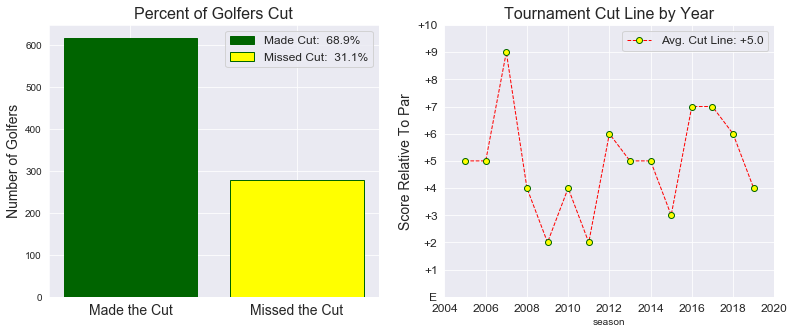

In [34]:
target_variable = 'made_cut'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Cut
height = df.groupby(target_variable).season.count().tolist()
missed_cut = height[0]
made_cut = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=made_cut,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Made Cut: {made_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Missed Cut: {missed_cut/(made_cut+missed_cut) : 0.1%}'
);
ax1.set_title("Percent of Golfers Cut", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Made the Cut', 'Missed the Cut'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper right', fontsize='large');

# Cutline overtime
avg_cutline = round(cut_lines['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

cut_lines.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Cut Line: +{avg_cutline}'
);
ax2.set_title("Tournament Cut Line by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.set_yticks(range(0, 11));
ax2.set_yticklabels(
    ('E', '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8', '+9', '+10')
);
ax2.set_xlim(2004, 2020);
ax2.legend(loc='upper right', fontsize='large');

### Top 10

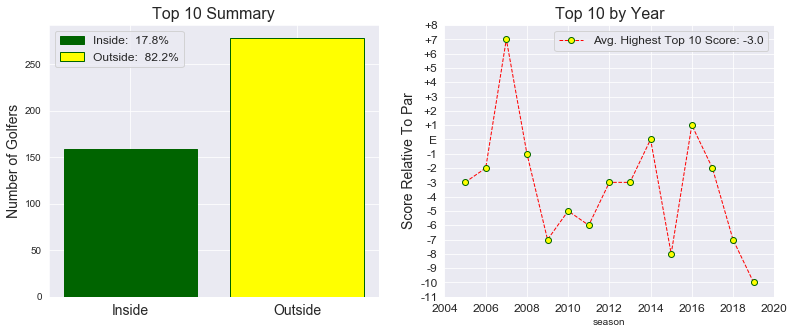

In [32]:
target_variable = 'top_10'
title = target_variable.replace('_', ' ').title()
fig = plt.figure(figsize=(13,5));

# Percent of Golfers Inside Top 10
height = df.groupby(target_variable).season.count().tolist()
outside_top10 = height[0]
inside_top10 = height[1]
ax1 = fig.add_subplot(121);
ax1.bar(
    x=0, 
    height=inside_top10,
    ec='darkgreen',
    fc='darkgreen',
    label=f'Inside: {inside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.bar(
    x=1, 
    height=missed_cut,
    ec='darkgreen',
    fc='yellow',
    label=f'Outside: {outside_top10/(inside_top10+outside_top10) : 0.1%}'
);
ax1.set_title("Top 10 Summary", {'fontsize' : 16});
ax1.set_ylabel('Number of Golfers', {'fontsize' : 14});
ax1.set_xticks(ticks=[0,1]);
ax1.set_xticklabels(labels=['Inside', 'Outside'], fontdict={'fontsize' : 14});
ax1.legend(loc='upper left', fontsize='large');

# Top 10 overtime
top_10 = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
top_10.reset_index(drop=False, inplace=True)
top_10['season'] = top_10['season']+1
top_10['relative_to_par'] = top_10['total_score']-(72*4)
avg_top10 = round(top_10['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

top_10.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Avg. Highest Top 10 Score: {avg_top10}'
);
ax2.set_title("Top 10 by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
ax2.set_yticks(range(-11, 9));
ax2.set_yticklabels(
    ('-11', '-10', '-9', '-8',
     '-7', '-6', '-5', '-4',
     '-3', '-2', '-1', 'E',
     '+1', '+2', '+3', '+4',
     '+5', '+6', '+7', '+8')
);
ax2.set_xlim(2004, 2020);

In [35]:
top10 = df[df['top_10'] == 1]
top10 = pd.DataFrame(top10['full_name'].value_counts())
top10.iloc[:5]

,full_name
tiger_woods,9
phil_mickelson,7
lee_westwood,5
rory_mcilroy,5
justin_rose,5


### Past Champions and Worst Performers

In [36]:
# Create a new dataframe that grabs golfers, their total experience, and number/pct of times they made the cut
experience = pd.DataFrame(df.groupby('full_name').experience.max())
experience.reset_index(drop=False, inplace=True)

cut_summary = pd.DataFrame(df.groupby('full_name').made_cut.sum())
cut_summary.reset_index(drop=False, inplace=True)

cut_summary = pd.merge(experience, cut_summary, how='outer', on='full_name')
cut_summary = cut_summary[['full_name', 'experience', 'made_cut']]
cut_summary['cuts_missed'] = cut_summary['experience'] - cut_summary['made_cut']
cut_summary['cuts_missed_pct'] = cut_summary['cuts_missed']/cut_summary['experience']*100
cut_summary = cut_summary[cut_summary['experience'] >= 4]

# Grab golfers that have missed more than 50% of cuts
augusta_hates = cut_summary[cut_summary['cuts_missed_pct'] >= 50]
raw_golfers = augusta_hates['full_name'].tolist()
golfers = [golfer.replace('_', ' ').title() for golfer in raw_golfers]
golfers = [golfer.replace('Iii', 'III') if golfer.endswith('Iii')
           else golfer for golfer in golfers]
augusta_hates['Golfers'] = golfers
augusta_hates.set_index('Golfers', inplace=True)
augusta_hates.sort_values(by='cuts_missed_pct', ascending=False, inplace=True)
augusta_hates

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,full_name,experience,made_cut,cuts_missed,cuts_missed_pct
Golfers,,,,,
Shaun Micheel,shaun_micheel,4,0,4,100.000000
Ben Curtis,ben_curtis,7,2,5,71.428571
Ben Crane,ben_crane,6,2,4,66.666667
Gary Woodland,gary_woodland,6,2,4,66.666667
Rory Sabbatini,rory_sabbatini,8,3,5,62.500000
Camilo Villegas,camilo_villegas,6,3,3,50.000000
Charles Howell III,charles_howell_iii,6,3,3,50.000000
Graeme Mcdowell,graeme_mcdowell,4,2,2,50.000000
John Senden,john_senden,6,3,3,50.000000


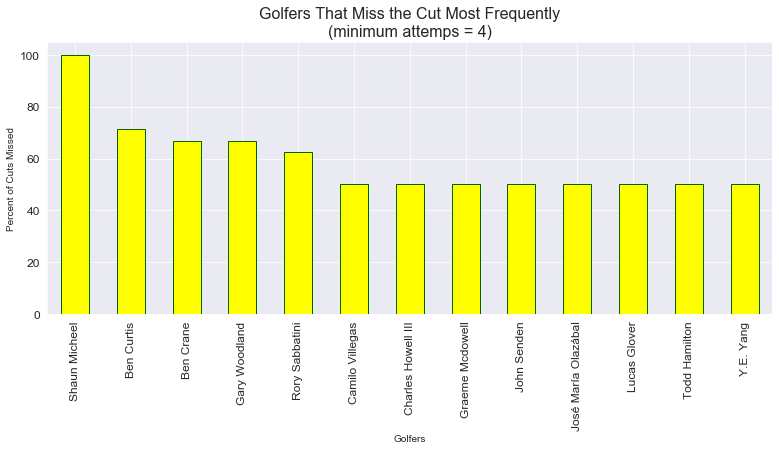

In [37]:
fig = plt.figure(figsize=(13,5));
ax = fig.add_subplot(111);
augusta_hates['cuts_missed_pct'].plot.bar(
    ax=ax,
    ec='darkgreen',
    fc='yellow',
    fontsize=12
);
ax.set_title(
    'Golfers That Miss the Cut Most Frequently\n(minimum attemps = 4)', 
    {'fontsize' : 16}
);
ax.set_ylabel('Percent of Cuts Missed');

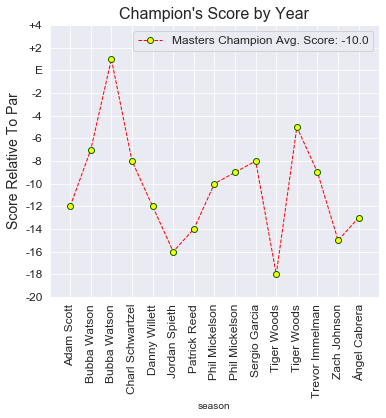

In [38]:
target_variable = 'champion'
title = 'Masters Champion'
fig = plt.figure(figsize=(13,5));

#Champion's score overtime
champion = pd.DataFrame(df[df[target_variable] == 1].groupby('season').total_score.max())
champion.reset_index(drop=False, inplace=True)
champion['season'] = champion['season']+1
champion['relative_to_par'] = champion['total_score']-(72*4)
avg_champion = round(champion['relative_to_par'].mean(), 0)
ax2 = fig.add_subplot(122);

champion.groupby('season').relative_to_par.mean().plot(
    kind='line',
    ax=ax2,
    fontsize=12,
    marker='o',
    mec='darkgreen',
    mfc='yellow',
    linestyle='--',
    linewidth=1.0,
    color='red',
    label=f'Masters Champion Avg. Score: {avg_champion}'
);
ax2.set_title("Champion's Score by Year", {'fontsize' : 16});
ax2.set_ylabel('Score Relative To Par', {'fontsize' : 14});
ax2.legend(loc='upper right', fontsize='large');
raw_champions = df[df['champion'] == 1].full_name.tolist()
champions = [champion.replace('_', ' ').title() for champion in raw_champions]
ax2.set_xticks(range(2005, 2020));
ax2.set_xticklabels(champions, rotation=90);
ax2.set_yticks(range(-20, 6, 2));
ax2.set_yticklabels(
    ('-20', '-18', '-16', '-14',
     '-12', '-10', '-8', '-6',
     '-4', '-2', 'E', '+2', '+4')
);
ax2.set_xlim(2004, 2020);

## Feature Exploration

### Strokes Gained Over Field

In [39]:
dataset = df[['season', 'full_name', 'experience', 'sg_roll_avg']]

exp1 = dataset[(dataset['experience'] < 6)].sg_roll_avg.mean()
exp2 = dataset[(dataset['experience'] > 5)&(dataset['experience'] < 11)].sg_roll_avg.mean()
exp3 = dataset[(dataset['experience'] > 11)].sg_roll_avg.mean()

print(exp1)
print(exp2)
print(exp3)

-3.97251720747296
4.147689452124936
6.250530171582804


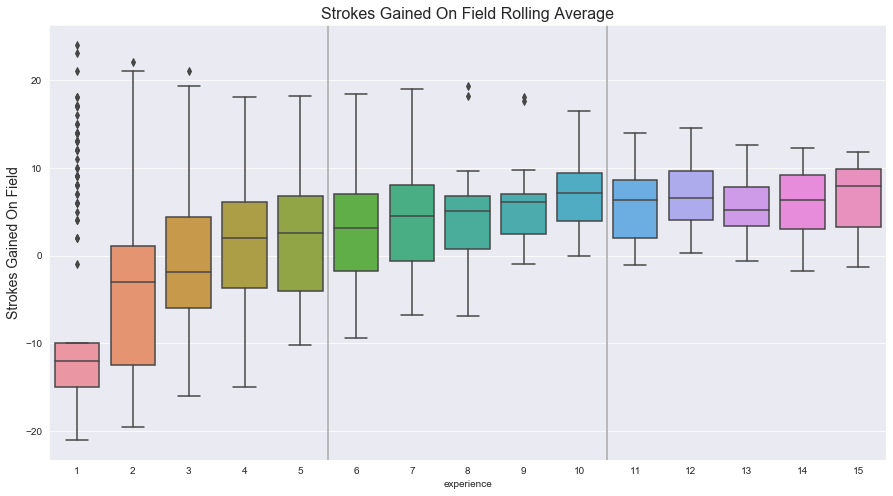

In [40]:
# Strokes Gained on field by experience
fig = plt.figure(figsize=figsize);
ax = fig.add_subplot(111);


sns.boxplot(
    x=dataset['experience'],
    y=dataset['sg_roll_avg']
);
ax.axvline(4.5, color='darkgray');
ax.axvline(9.5, color='darkgray');
ax.set_ylabel('Strokes Gained On Field', fontsize=14);
ax.set_title('Strokes Gained On Field Rolling Average', fontsize=16);

### Test for normality and linearity

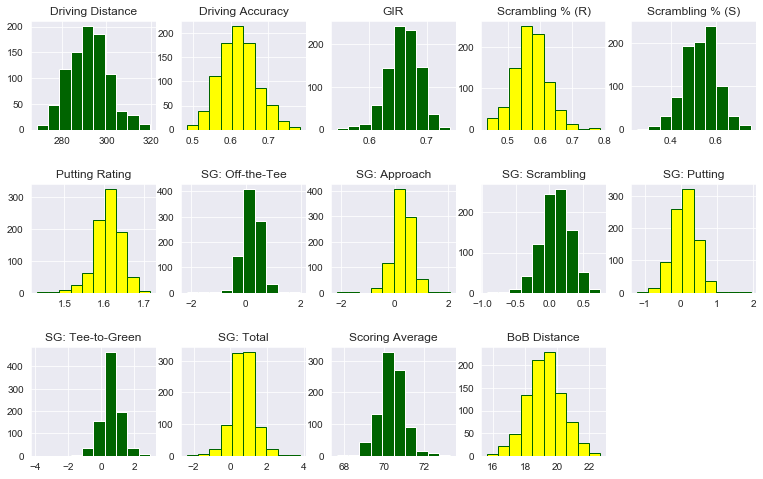

In [41]:
fig = plt.figure(figsize=(13, 8))
fig.subplots_adjust(hspace=hspace);

ax11 = fig.add_subplot(3,5,1);
ax11.hist(df['driving_distance'], fc = 'darkgreen');
ax11.set_title('Driving Distance');

ax12 = fig.add_subplot(3,5,2);
ax12.hist(df['driving_accuracy'], fc='yellow', ec='darkgreen');
ax12.set_title('Driving Accuracy');

ax13 = fig.add_subplot(3,5,3);
ax13.hist(df['greens_in_regulation'], fc = 'darkgreen');
ax13.set_title('GIR');

ax14 = fig.add_subplot(3,5,4);
ax14.hist(df['scrambling_rough'], fc='yellow', ec='darkgreen');
ax14.set_title('Scrambling % (R)');

ax21 = fig.add_subplot(3,5,5);
ax21.hist(df['scrambling_sand'], fc = 'darkgreen');
ax21.set_title('Scrambling % (S)');

ax22 = fig.add_subplot(3,5,6);
ax22.hist(df['putting_rating'], fc='yellow', ec='darkgreen');
ax22.set_title('Putting Rating');

ax23 = fig.add_subplot(3,5,7);
ax23.hist(df['sg_off_tee'], fc = 'darkgreen');
ax23.set_title('SG: Off-the-Tee');

ax24 = fig.add_subplot(3,5,8);
ax24.hist(df['sg_approach'], fc='yellow', ec='darkgreen');
ax24.set_title('SG: Approach');

ax31 = fig.add_subplot(3,5,9);
ax31.hist(df['sg_scrambling'], fc = 'darkgreen');
ax31.set_title('SG: Scrambling');

ax32 = fig.add_subplot(3,5,10);
ax32.hist(df['sg_putting'], fc='yellow', ec='darkgreen');
ax32.set_title('SG: Putting');

ax33 = fig.add_subplot(3,5,11);
ax33.hist(df['sg_tee_to_green'], fc = 'darkgreen');
ax33.set_title('SG: Tee-to-Green');

ax34 = fig.add_subplot(3,5,12);
ax34.hist(df['sg_total'], fc='yellow', ec='darkgreen');
ax34.set_title('SG: Total');

ax41 = fig.add_subplot(3,5,13);
ax41.hist(df['scoring_avg'], fc = 'darkgreen');
ax41.set_title('Scoring Average');

ax42 = fig.add_subplot(3,5,14);
ax42.hist(df['bob_distance'], fc='yellow', ec='darkgreen');
ax42.set_title('BoB Distance');

# Cut Classifications and Predictions

## Define Key Variables

In [42]:
# Random state
SEED = 13

# Split
test_size = 0.2

# Labels
target_names = ['missed_cut', 'made_cut']

FI_labels = df.drop(['full_name', 'season', 'champion', 'top_10',
                     'made_cut', 'total_score', 'prior_afs'], axis=1).columns.values

# K-folds Cross Validation
cv = 3

# Evaluation metric
scoring = 'f1'

## Train, Test, and Split

In [43]:
X = df.drop(['full_name', 'season', 'champion', 'top_10',
                     'made_cut', 'total_score', 'prior_afs'], axis=1)

y = df['made_cut']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

# We will use smote to handle our class imbalance
smt = SMOTE(random_state=SEED)
X_train, y_train = smt.fit_resample(X_train, y_train)

## Base Model

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    5.0s finished


------------------------------------------------------
Dummy Classifier Model Best Params:
------------------------------------------------------
 strategy : uniform
------------------------------------------------------
Dummy Classifier Model F1 Scores:
------------------------------------------------------
 train:  48.52%
 test:  62.04%
------------------------------------------------------
Dummy Classifier Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.35      0.54      0.42        56
    made_cut       0.72      0.54      0.62       123

    accuracy                           0.54       179
   macro avg       0.53      0.54      0.52       179
weighted avg       0.60      0.54      0.56       179

------------------------------------------------------


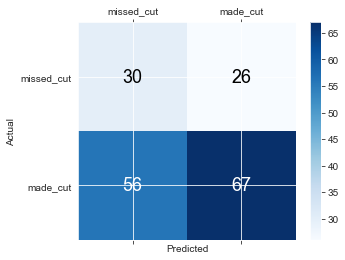

['models/noSG/base_model.pkl']

In [44]:
# Instantiate classifier and define model
classifier = DummyClassifier(random_state = SEED)
model_name = 'Dummy Classifier Model'

# Create param grid for GridSearch
param_grid = {
    'strategy' : [
        'stratified', 
        'most_frequent',
        'prior',
        'uniform',
        'constant'
    ]
}

# Instantiate GridSearch
dummy_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dummy_clf.fit(X_train, y_train)
y_hat_pred = dummy_clf.predict(X_train)
y_pred = dummy_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dummy_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/base_model.pkl'
model = dummy_clf
joblib.dump(model, filename)

## Logistic Regression

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.4s finished
/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


------------------------------------------------------
Logistic Regression Model Best Params:
------------------------------------------------------
 C : 1.0
 penalty : l1
 solver : liblinear
------------------------------------------------------
Logistic Regression Model F1 Scores:
------------------------------------------------------
 train:  63.09%
 test:  74.56%
------------------------------------------------------
Logistic Regression Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.49      0.64      0.55        56
    made_cut       0.81      0.69      0.75       123

    accuracy                           0.68       179
   macro avg       0.65      0.67      0.65       179
weighted avg       0.71      0.68      0.69       179

------------------------------------------------------


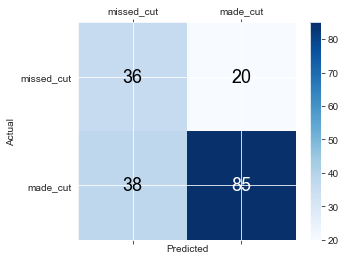

['models/noSG/log_model.pkl']

In [45]:
# Instantiate classifier and define model
classifier = LogisticRegression(random_state=SEED)
model_name = 'Logistic Regression Model'

# Create param grid for GridSearch
param_grid = {
    'penalty' : ['l1', 'l2'],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'C' : np.logspace(-10, 10, 5),
}

# Instantiate GridSearch
log_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
log_clf.fit(X_train, y_train)
y_hat_pred = log_clf.predict(X_train)
y_pred = log_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = log_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/log_model.pkl'
model = log_clf
joblib.dump(model, filename)

## KNearest Neighbors (KNN)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.5s finished


------------------------------------------------------
KNN Model Best Params:
------------------------------------------------------
 n_neighbors : 12
------------------------------------------------------
KNN Model F1 Scores:
------------------------------------------------------
 train:  63.80%
 test:  61.61%
------------------------------------------------------
KNN Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.36      0.59      0.45        56
    made_cut       0.74      0.53      0.62       123

    accuracy                           0.55       179
   macro avg       0.55      0.56      0.53       179
weighted avg       0.62      0.55      0.56       179

------------------------------------------------------


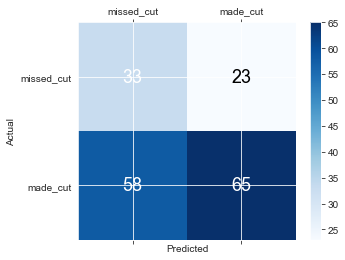

['models/noSG/knn_model.pkl']

In [56]:
# Instantiate classifier and define model
classifier = KNeighborsClassifier()
model_name = 'KNN Model'

# Define starting k
start = np.log(X_train.shape[0])
start = int(start)
stop = start+20

# Create param grid for GridSearch
param_grid = {'n_neighbors' : range(start,stop,2)}

# Instantiate GridSearch
knn_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
knn_clf.fit(X_train, y_train)
y_hat_pred = knn_clf.predict(X_train)
y_pred = knn_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = knn_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names = target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Pickle model
filename = 'models/noSG/knn_model.pkl'
model = knn_clf
joblib.dump(model, filename)

## Decision Tree

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s


------------------------------------------------------
Decision Tree Model Best Params:
------------------------------------------------------
 criterion : gini
 max_depth : 5
 min_samples_leaf : 10
 min_samples_split : 2
------------------------------------------------------
Decision Tree Model F1 Scores:
------------------------------------------------------
 train:  72.35%
 test:  75.83%
------------------------------------------------------
Decision Tree Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.48      0.54      0.51        56
    made_cut       0.78      0.74      0.76       123

    accuracy                           0.68       179
   macro avg       0.63      0.64      0.63       179
weighted avg       0.69      0.68      0.68       179

------------------------------------------------------


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:    1.9s finished


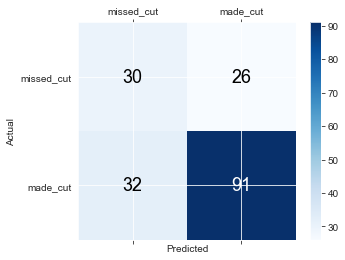

['models/noSG/dt_model.pkl']

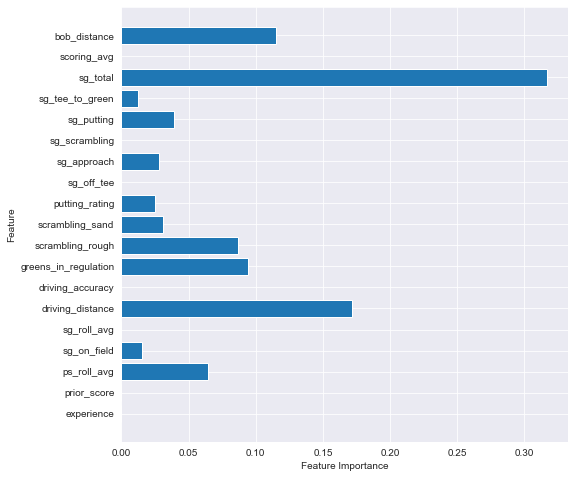

In [61]:
# Instantiate classifier and define model
classifier = DecisionTreeClassifier(random_state=SEED)
model_name = 'Decision Tree Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2, 5, 10],
    'min_samples_split' : [2, 5, 10],
    'min_samples_leaf' : [1, 2, 5, 10, 20]
}

# Instantiate GridSearch
dt_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
dt_clf.fit(X_train, y_train)
y_hat_pred = dt_clf.predict(X_train)
y_pred = dt_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = dt_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} F1 Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
dt_optimized = DecisionTreeClassifier(
    criterion = best_params['criterion'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

dt_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/dt_model.pkl'
model = dt_clf
joblib.dump(model, filename)

## Random Forest

Fitting 3 folds for each of 64 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed:   44.6s finished


------------------------------------------------------
Random Forest Model Best Params:
------------------------------------------------------
 criterion : gini
 max_depth : 5
 max_features : 15
 min_samples_leaf : 10
 min_samples_split : 10
 n_estimators : 100
------------------------------------------------------
Random Forest Model Precision Scores:
------------------------------------------------------
 train:  77.41%
 test:  73.45%
------------------------------------------------------
Random Forest Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.47      0.64      0.55        56
    made_cut       0.81      0.67      0.73       123

    accuracy                           0.66       179
   macro avg       0.64      0.66      0.64       179
weighted avg       0.70      0.66      0.68       179

------------------------------------------------------


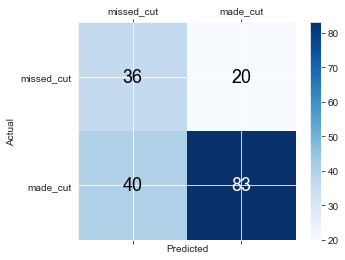

['models/noSG/rf_model.pkl']

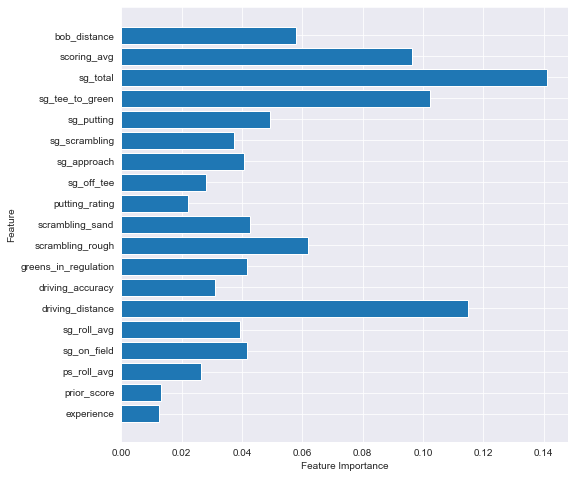

In [71]:
# Instantiate classifier and define model
classifier = RandomForestClassifier(random_state=SEED)
model_name = 'Random Forest Model'

# Create param grid for GridSearch
param_grid = {
    'criterion' : ['gini', 'entropy'],
    'n_estimators' : [100, 200],
    'max_features' : [10, 15],
    'max_depth' : [2, 5],
    'min_samples_split' : [10, 20],
    'min_samples_leaf' : [10, 20]
}

# Instantiate GridSearch
rf_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
rf_clf.fit(X_train, y_train)
y_hat_pred = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = rf_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
f1_hat = metrics.f1_score(y_train, y_hat_pred)
f1 = metrics.f1_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {f1_hat : 0.2%}')
print(f' test: {f1 : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
rf_optimized = RandomForestClassifier(
    criterion = best_params['criterion'],
    n_estimators = best_params['n_estimators'],
    max_features = best_params['max_features'],
    max_depth = best_params['max_depth'],
    min_samples_split = best_params['min_samples_split'],
    min_samples_leaf = best_params['min_samples_leaf'],
    random_state = SEED
)

rf_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, rf_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/rf_model.pkl'
model = rf_clf
joblib.dump(model, filename)

## AdaBoost

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    6.0s finished


------------------------------------------------------
AdaBoost Model Best Params:
------------------------------------------------------
 learning_rate : 1.0
 n_estimators : 150
------------------------------------------------------
AdaBoost Model Precision Scores:
------------------------------------------------------
 train:  87.96%
 test:  76.07%
------------------------------------------------------
AdaBoost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.45      0.50      0.47        56
    made_cut       0.76      0.72      0.74       123

    accuracy                           0.65       179
   macro avg       0.61      0.61      0.61       179
weighted avg       0.66      0.65      0.66       179

------------------------------------------------------


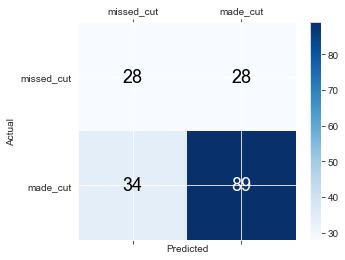

['models/noSG/ab_model.pkl']

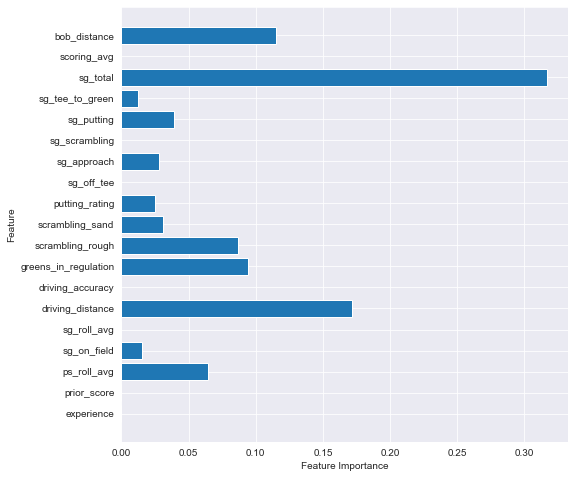

In [65]:
# Instantiate classifier and define model
classifier = AdaBoostClassifier(random_state=SEED)
model_name = 'AdaBoost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.1, 0.2, 0.5, 1.0]
}

# Instantiate GridSearch
ab_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
ab_clf.fit(X_train, y_train)
y_hat_pred = ab_clf.predict(X_train)
y_pred = ab_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = ab_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# # Print Precision-Recall Curve
# disp = metrics.plot_precision_recall_curve(ab_clf, X_test, y_test);

# Feature importance
ab_optimized = AdaBoostClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

ab_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/ab_model.pkl'
model = ab_clf
joblib.dump(model, filename)

## Gradient Boost

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    5.5s finished


------------------------------------------------------
Gradient Boost Model Best Params:
------------------------------------------------------
 learning_rate : 0.2
 n_estimators : 100
------------------------------------------------------
Gradient Boost Model Precision Scores:
------------------------------------------------------
 train:  99.38%
 test:  75.41%
------------------------------------------------------
Gradient Boost Model Classification Report
------------------------------------------------------
              precision    recall  f1-score   support

  missed_cut       0.46      0.46      0.46        56
    made_cut       0.75      0.75      0.75       123

    accuracy                           0.66       179
   macro avg       0.61      0.61      0.61       179
weighted avg       0.66      0.66      0.66       179

------------------------------------------------------


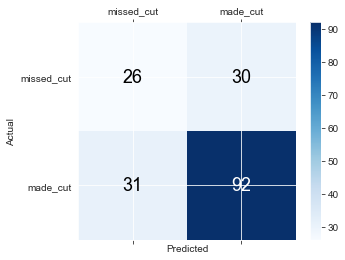

['models/noSG/gb_model.pkl']

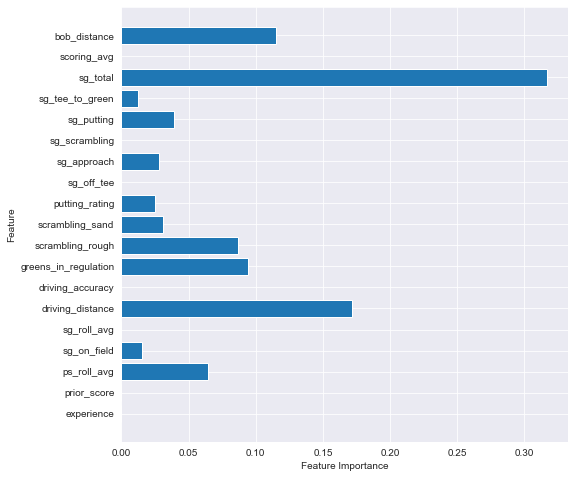

In [66]:
# Instantiate classifier and define model
classifier = GradientBoostingClassifier(random_state=SEED)
model_name = 'Gradient Boost Model'

# Create param grid for GridSearch
param_grid = {
    'n_estimators' : [50, 100, 150],
    'learning_rate' : [0.1, 0.2, 0.5, 1.0]
}

# Instantiate GridSearch
gb_clf = GridSearchCV(
    classifier,
    param_grid,
    cv=cv,
    scoring=scoring,
    verbose=2,
    n_jobs=-1
)

# Fit and make predictions
gb_clf.fit(X_train, y_train)
y_hat_pred = gb_clf.predict(X_train)
y_pred = gb_clf.predict(X_test)

# Print Best Params
print('--'*27)
print(f'{model_name} Best Params:')
print('--'*27)
best_params = gb_clf.best_params_
keys = list(best_params.keys())
for key in keys:
    print(f" {key} : {best_params[key]}")

# Print Precision Score
p_hat = metrics.precision_score(y_train, y_hat_pred)
p = metrics.precision_score(y_test, y_pred)
print('--'*27)
print(f'{model_name} Precision Scores:')
print('--'*27)
print(f' train: {p_hat : 0.2%}')
print(f' test: {p : 0.2%}')

# Print classification report
print('--'*27)
print(f'{model_name} Classification Report')
print('--'*27)
print(metrics.classification_report(y_test, y_pred, target_names=target_names))
print('--'*27)

# Print confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
classes = target_names
plot_confusion_matrix(cm, classes)

# Feature importance
gb_optimized = GradientBoostingClassifier(
    n_estimators = best_params['n_estimators'],
    learning_rate = best_params['learning_rate'],
    random_state = SEED
)

gb_optimized.fit(X_train, y_train)

n_features = X_train.shape[1]
plot_feature_importances(X_train, dt_optimized, n_features, FI_labels)

# Pickle model
filename = 'models/noSG/gb_model.pkl'
model = gb_clf
joblib.dump(model, filename)

## Results Summary

In [72]:
classifiers = [dummy_clf, log_clf, knn_clf, dt_clf, rf_clf, ab_clf, gb_clf]
names = ['base', 'log_reg', 'knn', 'decTree', 'randomF', 'adaB', 'gradB']
results = []
for index, classifier in enumerate(classifiers):
    result = {}
    y_hat_pred = classifier.predict(X_train)
    y_pred = classifier.predict(X_test)
    result['model'] = names[index]
    result['accuracy'] = round(metrics.accuracy_score(y_test, y_pred)*100,2)
    result['precision'] = round(metrics.precision_score(y_test, y_pred)*100,2)
    result['recall'] = round(metrics.recall_score(y_test, y_pred)*100,2)
    result['f1'] = round(metrics.f1_score(y_test, y_pred)*100,2)
    results.append(result)

results_df = pd.DataFrame(results)

print(results_df.shape)
results_df

(7, 5)


,model,accuracy,precision,recall,f1
0,base,54.19,72.04,54.47,62.04
1,log_reg,67.60,80.95,69.11,74.56
2,knn,54.75,73.86,52.85,61.61
3,decTree,67.60,77.78,73.98,75.83
4,randomF,66.48,80.58,67.48,73.45
5,adaB,65.36,76.07,72.36,74.17
6,gradB,65.92,75.41,74.80,75.10


## Make a Prediction

In [143]:
# Create X from holdout set and examine dataframe
X_holdout = holdout.drop(['full_name', 'season', 'champion', 'top_10',
                     'made_cut', 'total_score', 'prior_afs'], axis=1)

print(X_holdout.shape)
X_holdout.head()

(58, 19)


,experience,prior_score,ps_roll_avg,sg_on_field,sg_roll_avg,driving_distance,driving_accuracy,greens_in_regulation,scrambling_rough,scrambling_sand,putting_rating,sg_off_tee,sg_approach,sg_scrambling,sg_putting,sg_tee_to_green,sg_total,scoring_avg,bob_distance
6,1,315,315.000000,-20,-20.000000,293.3,0.7021,0.6679,0.5769,0.4943,1.600,0.575,0.011,-0.005,-0.065,0.580,0.515,70.580,19.341949
24,16,282,291.750000,13,8.250000,299.3,0.5991,0.6894,0.6316,0.5167,1.613,0.285,0.846,0.351,0.348,1.483,1.831,69.693,20.636098
93,11,315,297.727273,-20,1.727273,287.2,0.6325,0.6493,0.5824,0.6116,1.574,-0.193,0.083,0.480,0.592,0.370,0.962,70.520,20.668645
113,5,276,291.800000,19,6.400000,309.0,0.6183,0.6997,0.5859,0.5814,1.604,0.468,0.636,0.036,0.226,1.140,1.366,69.395,20.040437
116,3,284,296.666667,11,-0.666667,302.5,0.6502,0.6620,0.5974,0.5067,1.584,0.421,0.236,-0.016,0.372,0.641,1.013,70.177,21.500296


In [168]:
# Define golfers that will make the cut
weekend_field = dt_clf.predict(X_holdout)

print(weekend_field.shape)

(58,)


In [169]:
# Create new dataframe with features used in regressiom to predict if golfer makes the cut
made_cut = pd.DataFrame(holdout[['full_name', 'driving_distance', 'driving_accuracy',
          'greens_in_regulation', 'bob_distance', 
          'scrambling_rough', 'scrambling_sand',
          'putting_rating', 'scoring_avg']])

# Examine dataframe
print(made_cut.shape)
made_cut.head()

(58, 9)


,full_name,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg
6,abraham_ancer,293.3,0.7021,0.6679,19.341949,0.5769,0.4943,1.600,70.580
24,adam_scott,299.3,0.5991,0.6894,20.636098,0.6316,0.5167,1.613,69.693
93,brandt_snedeker,287.2,0.6325,0.6493,20.668645,0.5824,0.6116,1.574,70.520
113,brooks_koepka,309.0,0.6183,0.6997,20.040437,0.5859,0.5814,1.604,69.395
116,bryson_dechambeau,302.5,0.6502,0.6620,21.500296,0.5974,0.5067,1.584,70.177


In [170]:
# Add predictions to the made_cut dataframe
made_cut['made_cut'] = weekend_field

#Examine dataframe
print(made_cut.shape)
made_cut.head()

(58, 10)


,full_name,driving_distance,driving_accuracy,greens_in_regulation,bob_distance,scrambling_rough,scrambling_sand,putting_rating,scoring_avg,made_cut
6,abraham_ancer,293.3,0.7021,0.6679,19.341949,0.5769,0.4943,1.600,70.580,0
24,adam_scott,299.3,0.5991,0.6894,20.636098,0.6316,0.5167,1.613,69.693,1
93,brandt_snedeker,287.2,0.6325,0.6493,20.668645,0.5824,0.6116,1.574,70.520,1
113,brooks_koepka,309.0,0.6183,0.6997,20.040437,0.5859,0.5814,1.604,69.395,1
116,bryson_dechambeau,302.5,0.6502,0.6620,21.500296,0.5974,0.5067,1.584,70.177,1


In [171]:
# Save predictions
made_cut.to_csv('made_cut_predictions.csv')

# Predicting the Score

## Linear Regression

### Define Key Variables

In [172]:
regression_df = df[df['made_cut'] ==1]

outcome = 'total_score'

x_cols = ['driving_distance', 'driving_accuracy',
          'greens_in_regulation', 'bob_distance', 
          'scrambling_rough', 'scrambling_sand',
          'putting_rating', 'scoring_avg']

In [173]:
len(x_cols)

8

### Feature Correlations

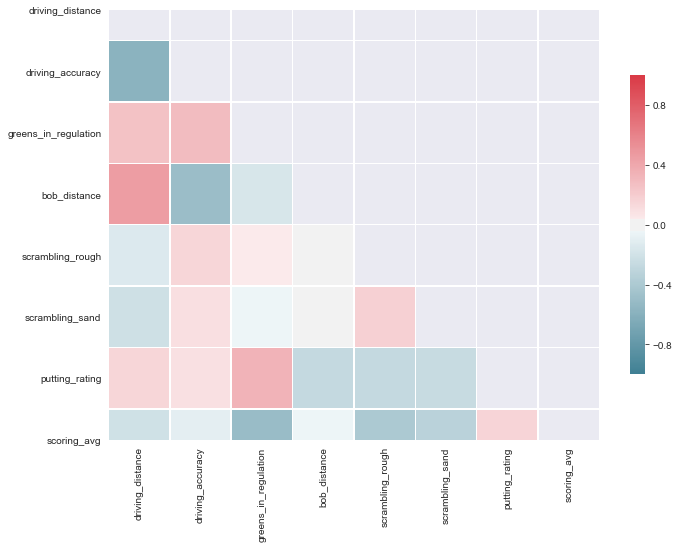

In [174]:
df_corr = regression_df[x_cols]

fig = plt.figure(figsize=(11,11))

# Create mask
mask = np.zeros_like(df_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Create color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax1 = fig.add_subplot(111)
sns.heatmap(df_corr.corr(),
            mask=mask, 
            cmap=cmap,
            center=0,
            vmin=-1,
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5},
            ax=ax1);

### Run OLS - Examine Ridge, Lasso, and Unpen. Linear Regression RMSEs

In [175]:
predictors = '+'.join(x_cols)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=regression_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_score   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     6.615
Date:                Sun, 19 Jan 2020   Prob (F-statistic):           2.63e-08
Time:                        10:29:20   Log-Likelihood:                -2023.1
No. Observations:                 617   AIC:                             4064.
Df Residuals:                     608   BIC:                             4104.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              209.4190     51.693      4.051      0.000     107.901     310.937
driving_distance        -0.1555      0.049     -3.204      0.001      -0.251      -0.060
driving_accuracy        -0.2752      8.315     -0.033      0.974     -16.604      16.054
greens_in_regulation     9.5849     14.380      0.667      0.505     -18.656      37.826
bob_distance             0.1182      0.293      0.403      0.687      -0.458       0.694
scrambling_rough        -7.2359      5.827     -1.242      0.215     -18.679       4.207
scrambling_sand         -1.9771      4.032     -0.490      0.624      -9.895       5.941
putting_rating           2.3955      9.478      0.253      0.801     -16.217      21.008
scoring_avg              1.6800      0.593      2.831      0.005       0.515       2.845
==============================================================================
Omnibus:                        3.047   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.879
Skew:                           0.161   Prob(JB):                        0.237
Kurtosis:                       3.091   Cond. No.                     6.05e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

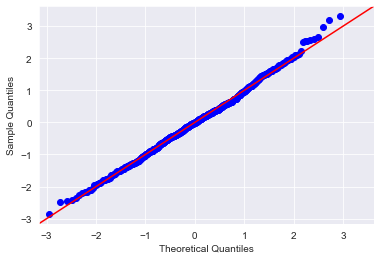

In [176]:
fig = sm.graphics.qqplot(model.resid, dist = stats.norm, line='45', fit = True);

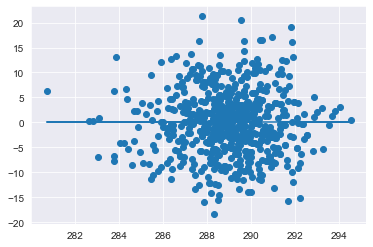

In [177]:
plt.scatter(model.predict(regression_df[x_cols]), model.resid);
plt.plot(model.predict(regression_df[x_cols]), [0 for i in range(len(regression_df))]);

In [179]:
X = regression_df.drop(['full_name', 'season', 'experience',
                        'champion', 'top_10', 'made_cut',
                        'total_score', 'prior_score', 'ps_roll_avg',
                        'prior_afs', 'sg_on_field', 'sg_roll_avg',
                        'sg_off_tee', 'sg_approach', 'sg_scrambling',
                        'sg_putting', 'sg_tee_to_green', 'sg_total'], axis=1)
y = regression_df['total_score']

In [180]:
len(X.columns)

8

In [181]:
print(X.shape)
print(y.shape)

(617, 8)
(617,)


In [182]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED)

In [183]:
print(X_train.shape)
print(y_train.shape)

(493, 8)
(493,)


In [184]:
std = StandardScaler()

X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [185]:
print(X_train.shape)
print(X_test.shape)

(493, 8)
(124, 8)


In [186]:
# Ridge
ridge = Ridge(alpha=1)
ridge.fit(X_train, y_train)

# Lasso
lasso = Lasso(alpha=1)
lasso.fit(X_train, y_train)

#Linear
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [187]:
#ridge predictions
y_h_ridge_train = ridge.predict(X_train)
y_h_ridge_test = ridge.predict(X_test)

#generate predications for the lasso regression
y_h_lasso_train = lasso.predict(X_train)
y_h_lasso_test = lasso.predict(X_test)

#linear predications
y_h_lin_train = linear.predict(X_train)
y_h_lin_test = linear.predict(X_test)

In [188]:
print('Train RMSE Ridge Model', np.sqrt(np.sum((y_train - y_h_ridge_train)**2)/df.shape[0]))
print('Test RMSE Ridge Model', np.sqrt(np.sum((y_test - y_h_ridge_test)**2)/df.shape[0]))
print('\n')

print('Train RMSE Lasso Model', np.sqrt(np.sum((y_train - y_h_lasso_train)**2)/df.shape[0]))
print('Test RMSE Lasso Model', np.sqrt(np.sum((y_test - y_h_lasso_test)**2)/df.shape[0]))
print('\n')

print('Train RMSE Linear Model', np.sqrt(np.sum((y_train - y_h_lin_train)**2)/df.shape[0]))
print('Test RMSE Linear Model', np.sqrt(np.sum((y_test - y_h_lin_test)**2)/df.shape[0]))

Train RMSE Ridge Model 4.691375776518825
Test RMSE Ridge Model 2.5684381380389283


Train RMSE Lasso Model 4.820927946812995
Test RMSE Lasso Model 2.6306982805992893


Train RMSE Linear Model 4.691374835325564
Test RMSE Linear Model 2.5684284152745103


In [189]:
X = std.transform(X)
lin = linear.fit(X, y)

In [190]:
weekend_field = made_cut[made_cut['made_cut']==1]
cut = made_cut[made_cut['made_cut']==0]

In [191]:
print(weekend_field.shape)

(46, 10)


In [192]:
validation_set = weekend_field.drop(['full_name', 'made_cut'], axis=1)
validation_set.shape

(46, 8)

In [193]:
validation_set = std.fit_transform(validation_set)

In [194]:
validation_set.shape

(46, 8)

In [195]:
predictions=lin.predict(validation_set)

In [196]:
len(predictions)

46

In [197]:
weekend_field['predictions'] = predictions
lin_reg_results = weekend_field[['full_name', 'predictions']]
lin_reg_results.sort_values(by='predictions')

/Users/JacquesPierre/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,full_name,predictions
712,rory_mcilroy,284.546715
445,justin_rose,285.371262
618,patrick_cantlay,285.876092
230,dustin_johnson,286.011619
577,matt_wallace,286.169003
579,matthew_wolff,286.758294
116,bryson_dechambeau,286.851923
876,tony_finau,286.900742
920,xander_schauffele,287.202503
680,rickie_fowler,287.261108


In [198]:
lin_reg_results.to_csv('csv_files/liner_regression_predictions.csv')